In [1]:
import numpy as np
import random
import pandas as pd 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math,time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import yfinance as yf

## Fetch price series of both assets in *optimal pair (found in previous sections)
## Calculuate spread of assets and normalise data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


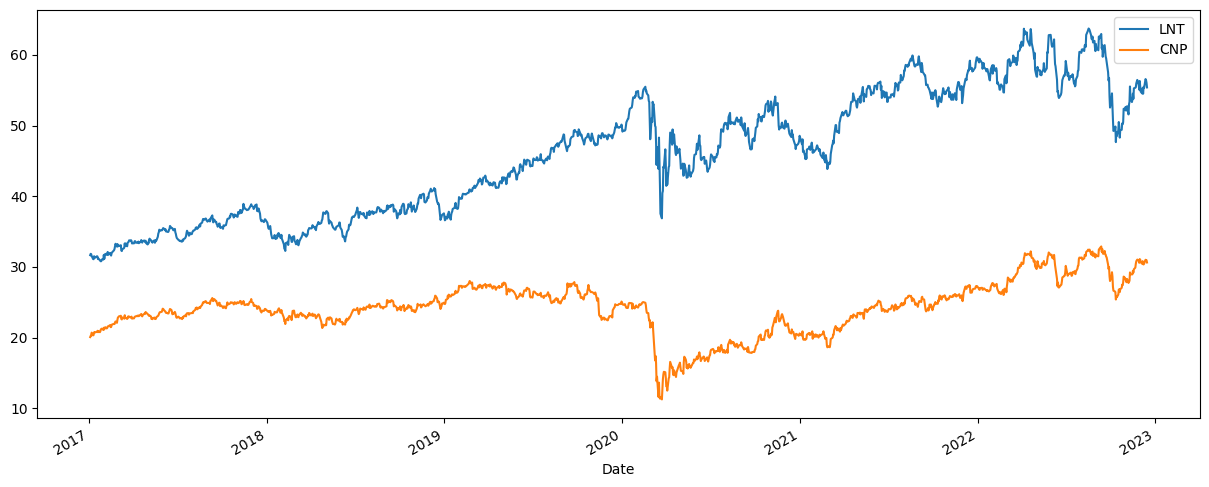

In [2]:
Asset1 = yf.download('LNT', start='2017-01-01', end='2022-12-16')
Asset1['Adj Close'].plot(figsize=(15,6),label='LNT')
Asset2 = yf.download('CNP', start='2017-01-01', end='2022-12-16')
Asset2['Adj Close'].plot(figsize=(15,6),label='CNP')
plt.legend()
plt.show()

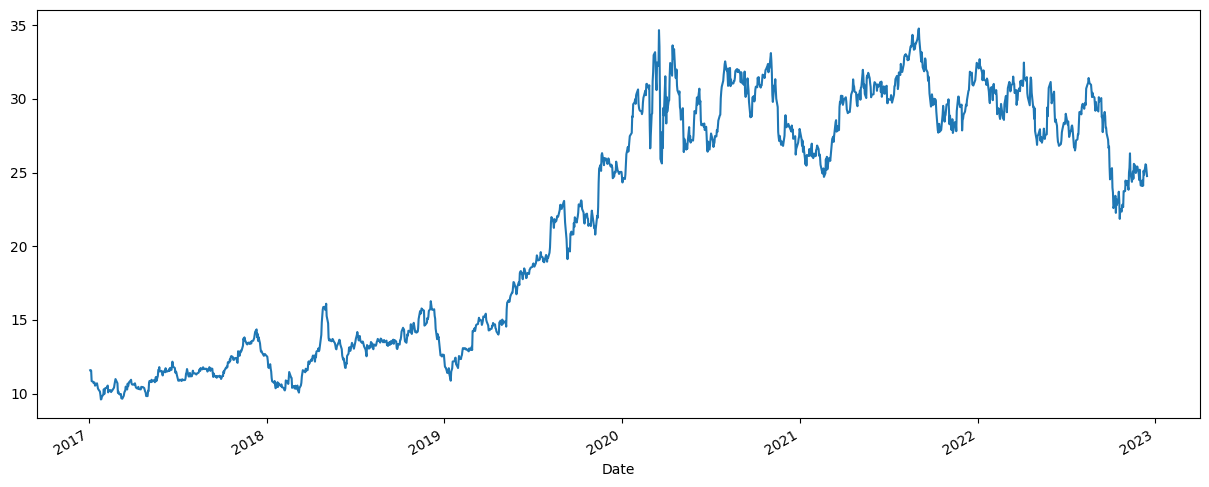

In [3]:
spread = np.abs(Asset1['Adj Close'] - Asset2['Adj Close'])
spread.plot(figsize=(15,6))
plt.show()

In [4]:
dates = pd.date_range('2017-01-03','2022-12-16',freq='B')
df1=pd.DataFrame(index=dates)
spread_df=df1.join(spread)
spread_df

,Adj Close
2017-01-03,11.586004
2017-01-04,11.598372
2017-01-05,11.556644
2017-01-06,10.848824
2017-01-09,10.806637
...,...
2022-12-12,25.559999
2022-12-13,25.509998
2022-12-14,25.099998
2022-12-15,24.760000


In [5]:
spread_df_norm=spread_df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
spread_df_norm['Adj Close'] = scaler.fit_transform(spread_df_norm['Adj Close'].values.reshape(-1,1))
spread_df_norm.head()

,Adj Close
2017-01-03,-0.842741
2017-01-04,-0.841758
2017-01-05,-0.845074
2017-01-06,-0.901334
2017-01-09,-0.904687


## Establish training validation testing split
## Define architecture of LSTM model
## Initialise LSTM model

In [6]:
def data(asset, look_back):
    asset = asset
    data = []
    
    #All combinations of data given look back value
    for i in range(len(asset) - look_back): 
        data.append(asset[i: i + look_back])
    
    data = np.array(data);
    test_len = int(np.round(0.25*data.shape[0]))
    train_val_len = data.shape[0] - (test_len)
    val_len = int(np.round(0.3*train_val_len))
    train_len= data.shape[0] - (val_len)-test_len

    x_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    
    x_val = data[train_len:train_len+val_len,:-1,:]
    y_val = data[train_len:train_len+val_len,-1,:]
    
    x_test = data[train_len+val_len:,:-1]
    y_test = data[train_len+val_len:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [7]:
look_back = 2 # choose sequence length
x_train, y_train,x_val,y_val, x_test, y_test = data(spread_df_norm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (815, 1, 1)
y_train.shape =  (815, 1)
x_val.shape =  (349, 1, 1)
y_val.shape =  (349, 1)
x_test.shape =  (388, 1, 1)
y_test.shape =  (388, 1)


In [8]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
y_train.size(),x_train.size(),y_val.size(),x_val.size(),y_test.size(),x_test.size() #confirm dimensions so can set the correct parameters for neural network below


(torch.Size([815, 1]),
 torch.Size([815, 1, 1]),
 torch.Size([349, 1]),
 torch.Size([349, 1, 1]),
 torch.Size([388, 1]),
 torch.Size([388, 1, 1]))

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() #make hidden state 0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #detach so can do truncated backprop 
        out = self.fc(out[:, -1, :]) 
        return out

## Hyperparamters chosen to minimise loss function
### *chose Adam optimiser as it converged most effectively

In [11]:
input_dim = 1
hidden_dim = 10
num_layers = 5
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 10, num_layers=5, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


## Fit model to training set 
### * 2000 epochs likely not necessary somewhere between 1000-1500 likely optimal for my particular set of data

In [12]:
num_epochs = 2000
hist = np.zeros(num_epochs)
seq_dim =look_back-1  

for t in range(num_epochs):
    y_train_prediction = model(x_train) #forward pass

    loss_ = loss(y_train_prediction, y_train)
    if t % 200 == 0 and t !=0:
        print("Epoch", t, "MSE: ", loss_.item())
    hist[t] = loss_.item()
    optimiser.zero_grad()
    loss_.backward() #backward pass
    optimiser.step() #update parameters

Epoch 200 MSE:  0.12613517045974731
Epoch 400 MSE:  0.016508108004927635
Epoch 600 MSE:  0.006398646626621485
Epoch 800 MSE:  0.0015138279413804412
Epoch 1000 MSE:  0.0006709129083901644
Epoch 1200 MSE:  0.0005842755199410021
Epoch 1400 MSE:  0.0005628627841360867
Epoch 1600 MSE:  0.0005551008507609367
Epoch 1800 MSE:  0.0005509908078238368


In [13]:
y_val_prediction=model(x_val)
y_test_prediction = model(x_test)

y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_val_prediction = scaler.inverse_transform(y_val_prediction.detach().numpy())
y_val = scaler.inverse_transform(y_val.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

#root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train RMSE Score:',trainScore)
valScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_prediction[:,0]))
print('Val RMSE Score:',valScore)
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test RMSE Score:', testScore)

Train RMSE Score: 0.2946103832072849
Val RMSE Score: 0.8812055901233643
Test RMSE Score: 0.9163862182301012


## Visualise forecasted verses actual spread of training validation and testing sets

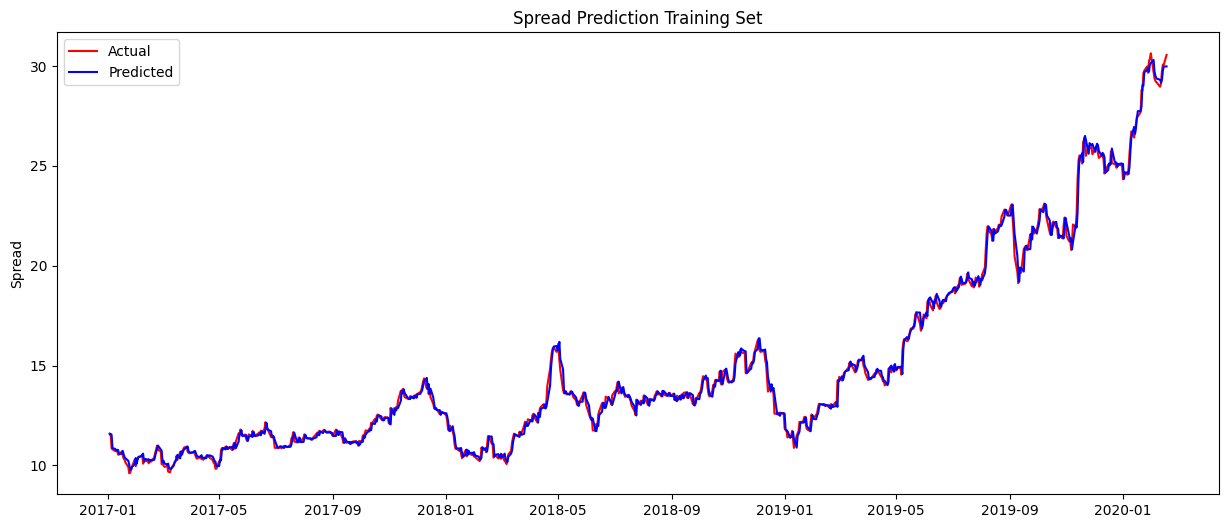

In [14]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[:len(y_train)].index, y_train, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[:len(y_train)].index, y_train_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Training Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

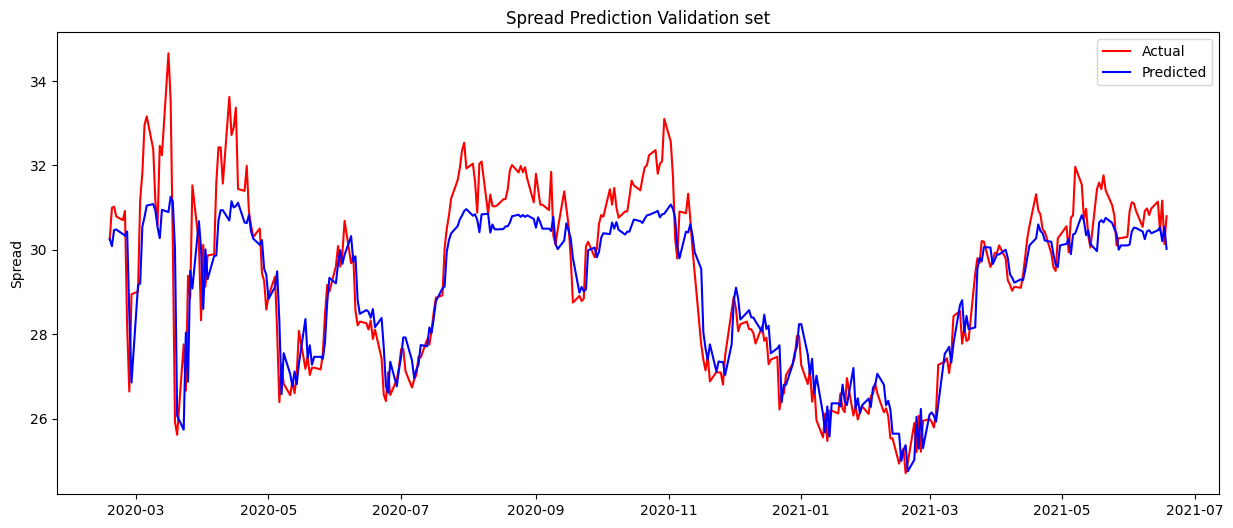

In [15]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Validation set')
plt.ylabel('Spread')
plt.legend()
plt.show()

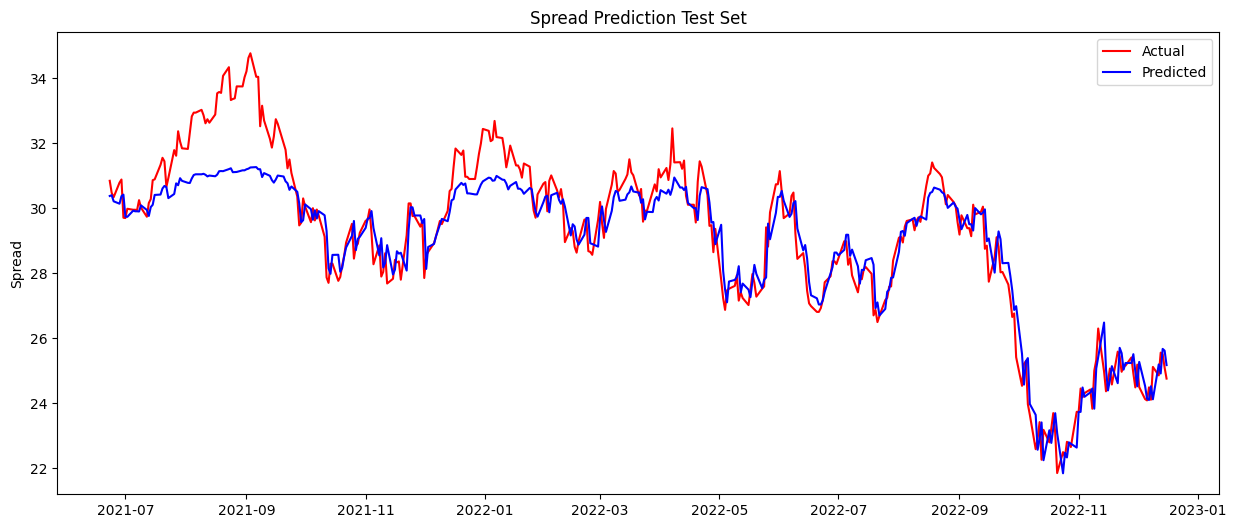

In [16]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Test Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

## Find optimal threshold - decile method


In [17]:
ydf=spread_df[0:len(y_train)].fillna(method='ffill')
y_perc_change=ydf.pct_change().fillna(method='bfill')['Adj Close']
negchange=[]
poschange=[]
for i in range(0,len(y_perc_change)):
    if y_perc_change[i]>= 0:
        poschange.append(y_perc_change[i])
    else:
        negchange.append(y_perc_change[i])

In [18]:
pospercentile=np.percentile(poschange, np.arange(0, 100, 10))
negpercentile=np.percentile(negchange, np.arange(0, 100, 10))
top_decile_threshold = pospercentile[-1]
bottom_decile_threshold = negpercentile[1]

In [19]:
print('Top decile threshold:',top_decile_threshold,'Bottom decile threshold:',bottom_decile_threshold)

Top decile threshold: 0.031868152445494596 Bottom decile threshold: -0.030564393362316953


## Use decile method on testing set to generate trade signals

In [22]:
#Percent change between forecast spread at time t+1 and actual spread at time 2
def percentage_change(col1,col2):
    return ((col2 - col1) / col1) 
perc_change=[]
for i in range(0,len(y_test)-1):
    
    percΔ=percentage_change(y_test[i],y_test_prediction[i+1])
    perc_change.append(percΔ)
    
perc=np.array(perc_change)


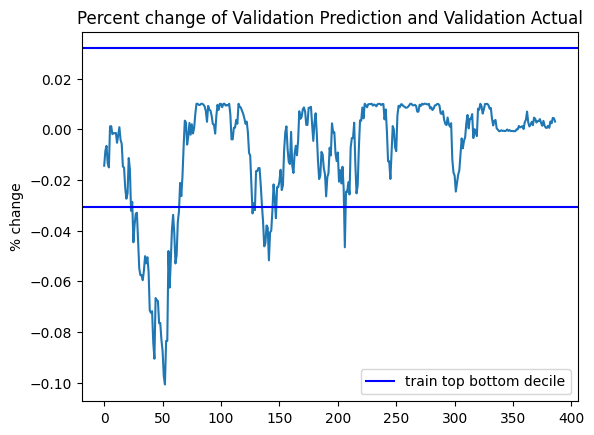

In [24]:
plt.plot(perc)
plt.axhline(y = bottom_decile_threshold, color = 'b', linestyle = '-',label='train top bottom decile')
plt.axhline(y = top_decile_threshold, color = 'b', linestyle = '-')
plt.title('Percent change of Test Prediction and Test Actual')
plt.ylabel('% change')
plt.legend()
plt.show()

## For this particular case our percent change never hits the top decile, but does intersect the bottom decile
## This means every transaction is either shorting the spread or closing an open trade

In [26]:
below_=[]
above_=[]
for i in range(0,len(perc)):       
    if perc[i]<= bottom_decile_threshold:
        below_.append(i)
    elif perc[i] >= top_decile_threshold:
        above_.append(i)

In [27]:
x_=[]
y_=[]
test_spread=spread_df[len(y_train)+len(y_val):]   
for i in range(0,len(below_)):
    x_.append(test_spread.index[below_[i]])
    y_.append(test_spread['Adj Close'][below_[i]])

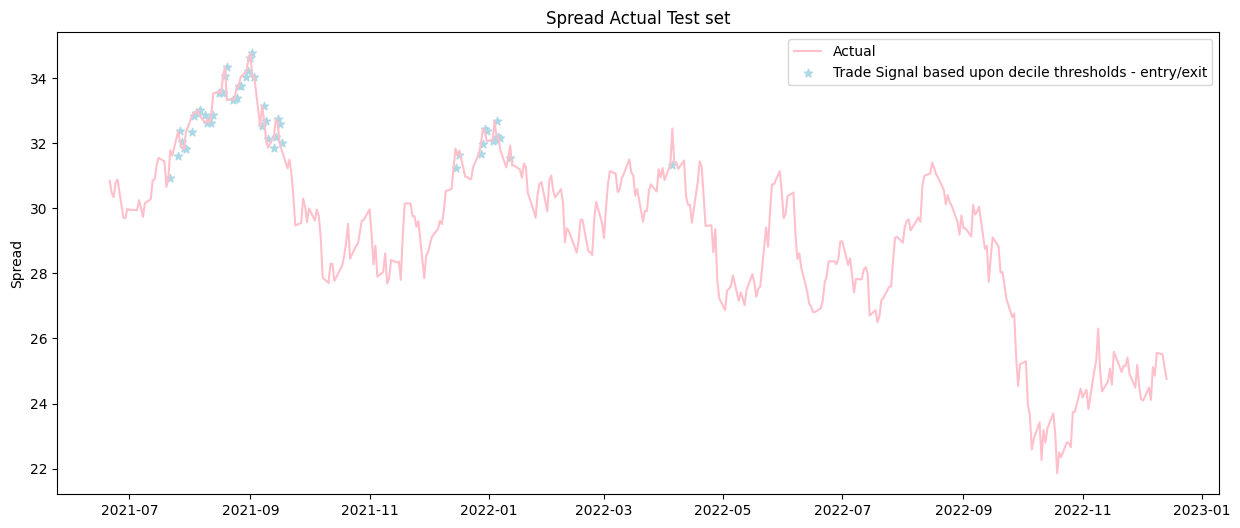

In [31]:
#decile method
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train)+len(y_val):-2].index, y_test, color = 'pink', label = 'Actual')
plt.scatter(x_, y_, marker="*", color="lightblue",label='Trade Signal based upon decile thresholds - entry/exit')
plt.title('Spread Actual Test set')
plt.ylabel('Spread')
plt.legend()
plt.show()

## To short the spread we will go long one asset and short the other depending on the ratio. When the ration of asset1:asset 2 is larger than its mean AND the percentage change of the spread has gone above or below our thresholds, we consider asset 1 to be over valued with respect to asset b and thus we will short asset 1 and long asset 2. When the ratio of asset1:asset2 is smaller than its mean we consider asset 2 over valued with respect to asset 1 and we will short asset 2 and long asset1. We keep these trades until our spread percent change reverts to within the bounds of our upper and lower threshold

In [38]:
test_spread=spread_df[len(y_train)+len(y_val):]
ratio = np.abs(Asset1['Adj Close']/Asset2['Adj Close'])
x_r_=[]
y_r_=[]   
for i in range(0,len(below_)):
    x_r_.append(test_ratio.index[below_[i]])
    y_r_.append(test_ratio[below_[i]])
test_ratio=ratio[len(y_train)+len(y_val):]

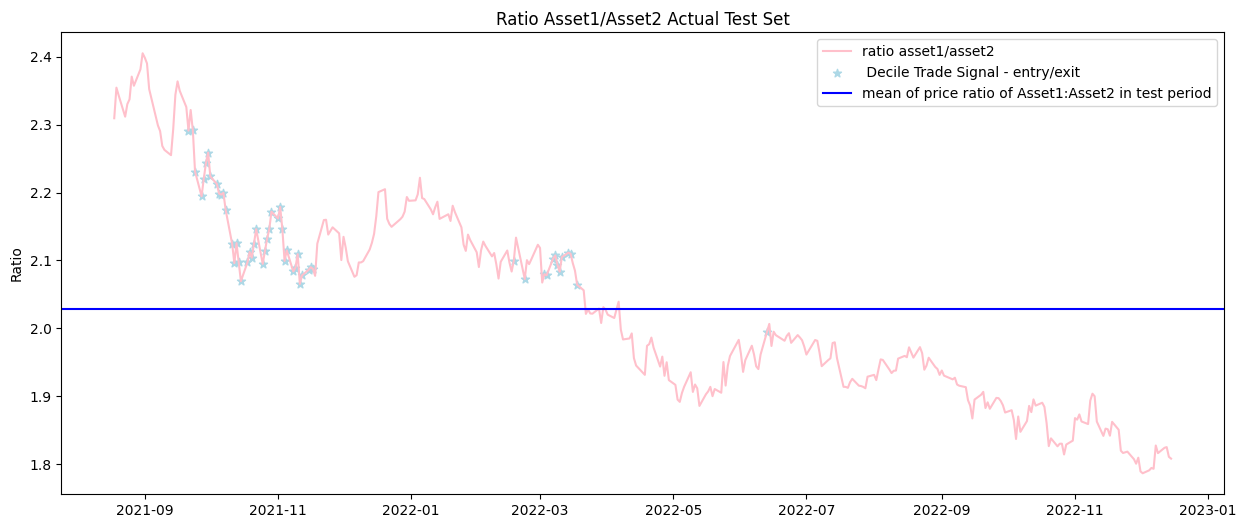

In [39]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(ratio[len(y_train)+len(y_val):].index, ratio[len(y_train)+len(y_val):], color = 'pink', label = 'ratio asset1/asset2')
plt.scatter(x_r_, y_r_, marker="*", color="lightblue",label=' Decile Trade Signal - entry/exit')
plt.axhline(y = ratio[len(y_train)+len(y_val):].mean(), color = 'b', linestyle = '-',label='mean of price ratio of Asset1:Asset2 in test period')
plt.title('Ratio Asset1/Asset2 Actual Test Set')
plt.ylabel('Ratio')
plt.legend()
plt.show()

In [46]:
#asset 1 overvalued when ratio above mean -> sell asset 1 long asset 2
#asset 2 overvalue when ratio below mean -> sell asset2 long asset2
#calculate positions
positions=pd.DataFrame(index=ratio[len(y_train)+len(y_val):].index, columns = ['Asset1','Asset2','l/s spread'])
position_open=False
for date in range(0,len(test_ratio)):
    
    #if no position is open
    if position_open==False:
        if perc[date] <= bottom_decile_threshold:
            position_open = True
            if test_ratio[date] >= test_ratio.mean():
                positions.loc[test_ratio.index[date]] = [-1,1,'short spread']
            else:
                positions.loc[test_ratio.index[date]] = [1,-1,'short spread']
        else:
            position_open = False
            if test_ratio[date] >= test_ratio.mean():
                positions.loc[test_ratio.index[date]] = [0,0,'no change']
            else:
                positions.loc[test_ratio.index[date]] = [0,0,'no change']
    # if position is open            
    if position_open == True:
        if perc[date] <= bottom_decile_threshold:
            position_open= True
            if test_ratio[date] >= test_ratio.mean():
                positions.loc[test_ratio.index[date]] = [-1,1,'no change']
            else:
                positions.loc[test_ratio.index[date]] = [1,-1,'no change']
        else:
            position_open=False
            if test_ratio[date] >= test_ratio.mean():
                positions.loc[test_ratio.index[date]] = [0,0,'close trade']
            else:
                positions.loc[test_ratio.index[date]] = [0,0,'close trade']    

## Calculate log returns of assets and find the algorithms returns for validation set. Compare our algorithm returns with the appropriate index based on cluster (in this case we are showing an optimal pair from the utility cluster, so I will use VPU Vanguard utility Index etf as a comparison)

In [52]:
Asset1 = yf.download('LNT', start='2017-01-01', end='2022-12-16')
Asset1['log_ret1'] = np.log(Asset1['Adj Close']) - np.log(Asset1['Adj Close'].shift(1))
logret1=Asset1['log_ret1'][len(y_train)+len(y_val):]
logret1c=logret1.cumsum()

Asset2 = yf.download('CNP', start='2017-01-01', end='2022-12-16')
Asset2['log_ret2'] = np.log(Asset2['Adj Close']) - np.log(Asset2['Adj Close'].shift(1))
logret2=Asset2['log_ret2'][len(y_train)+len(y_val):]
logret2c=logret2.cumsum()
p=positions.join(logret1)
z=p.join(logret2).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [53]:
# calculate returns
algo_ret = (z['Asset1']*z['log_ret1'].shift()+z['Asset2']*z['log_ret2'].shift())

[*********************100%***********************]  1 of 1 completed


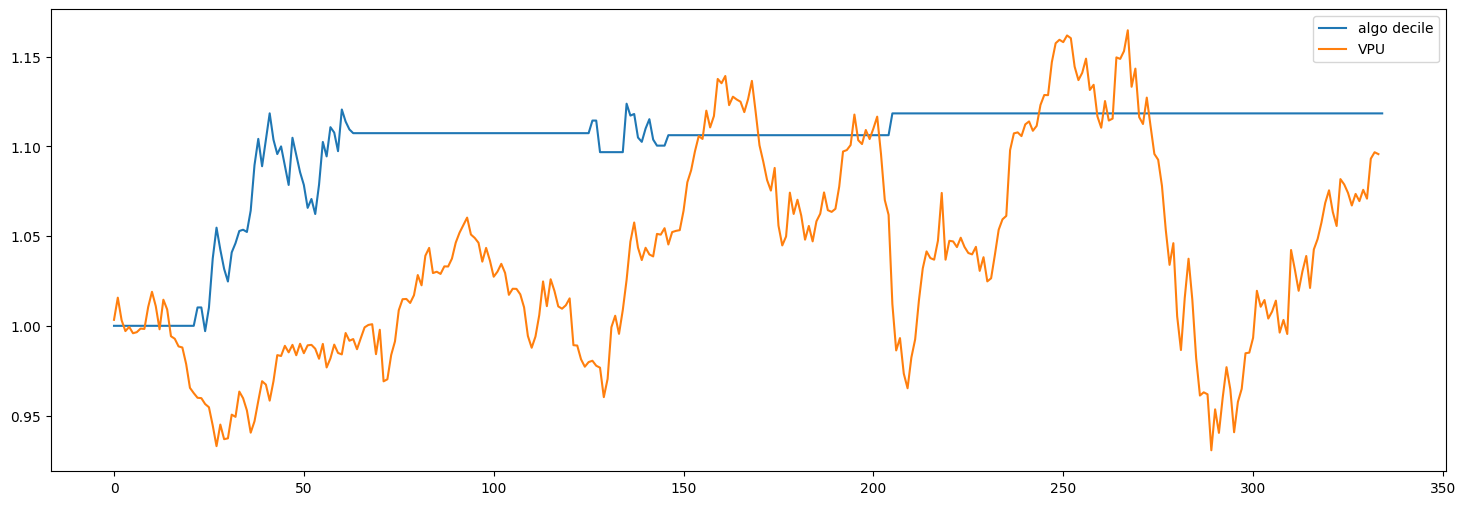

In [54]:
algo_ret=algo_ret.dropna()
returns_dec=[]
for i in range(0,len(algo_ret)):
    returns_dec.append(np.exp(algo_ret[i])-1)

index_price = yf.download('VPU', start=Asset1[len(y_train)+len(y_val):].index[0], end=Asset1[len(y_train)+len(y_val):].index[-1])
index_price = index_price['Adj Close']
index_ret =index_price.pct_change().dropna()

plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(np.array(returns_dec)+1), label='algo decile')
plt.plot(np.nancumprod(index_ret + 1), label='VPU')
plt.legend()
plt.show()

In [55]:
def calculate_metrics(cumret):
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [58]:
#performance metrics
metrics = pd.DataFrame(index=['Decile Algo','VPU'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Length Drawdown'])
metrics.loc['Decile Algo'] = calculate_metrics(np.nancumprod(np.array(returns_dec)+1))
metrics.loc['VPU'] = calculate_metrics(np.nancumprod(index_ret + 1))

metrics

,Total return,APR,Sharpe,Max Drawdown,Max Length Drawdown
Decile Algo,0.118423,0.087836,1.132332,-0.050187,199.0
VPU,0.092081,0.068717,0.439995,-0.201023,85.0


## Nice! Our LSTM decile method performed better than the benchmark index during the time period of our testing set.